In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

In [11]:
import torchvision.datasets as dset #데이터셋, 모델, 이미지 포함
import torchvision.transforms as transforms #불러온 이미지의 변환
from torch.utils.data import DataLoader #배치사이즈대로 묶어서 전달할때 묶거나 섞을 수 있는 클래스

In [12]:
import matplotlib.pylab as plt
import numpy as np
from tqdm import tqdm

In [13]:
#download mnist
mnist_train = dset.MNIST(root='./data/mnist', train=True, transform=transforms.ToTensor(),target_transform=None ,download=True)
mnist_test  = dset.MNIST(root='./data/mnist', train=False, transform=transforms.ToTensor(),target_transform=None ,download=True)

train_loadaer = DataLoader(mnist_train, batch_size=512, shuffle=True, num_workers=2, drop_last = True)
test_loader   = DataLoader(mnist_test, batch_size=512, shuffle=False, num_workers=2, drop_last = True)
print("download 완료!")

download 완료!


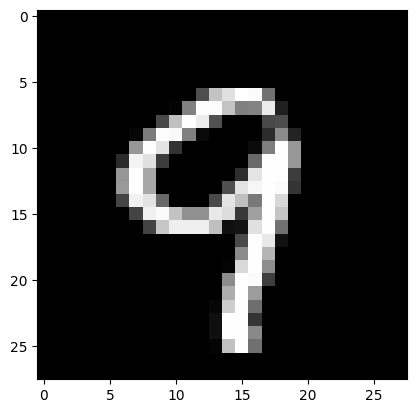

label : 9
shape : torch.Size([1, 28, 28])


In [14]:
#check data
random_num = np.random.randint(0, 10000)
plt.imshow(mnist_test[random_num][0].reshape(-1,28),cmap="gray")
plt.show()
print(f"label : {mnist_test[random_num][1]}")
print(f"shape : {mnist_test[random_num][0].shape}")

In [27]:
lr = 0.00002
EPOCH = 500

In [28]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            #conv
            nn.Conv2d(1,16,5), # 28 -> 24
            nn.ReLU(),
            nn.Conv2d(16,32,5), # 24 -> 20
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 20 -> 10
            nn.Conv2d(32,64,5), # 10 -> 6
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 6 -> 3
        )

        self.fc = nn.Sequential(
            nn.Linear(64*3*3, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
        )

    def forward(self, x):
        out = self.layer(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [30]:
loss_arr = []
for i in tqdm(range(EPOCH)):
    loss_sum = 0
    for [image,label] in test_loader:  #enumerate 사용시 인덱스와 튜플을 같이 넘겨줌
        x = image.to(device)
        y = label.to(device)

        output = model.forward(x)
        _,output_max = torch.max(output,1)

        loss = loss_func(output,y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.cpu().detach().numpy()
    loss_arr.append(loss_sum)
    

print("train 완료!")
        


100%|██████████| 500/500 [03:52<00:00,  2.15it/s]

train 완료!


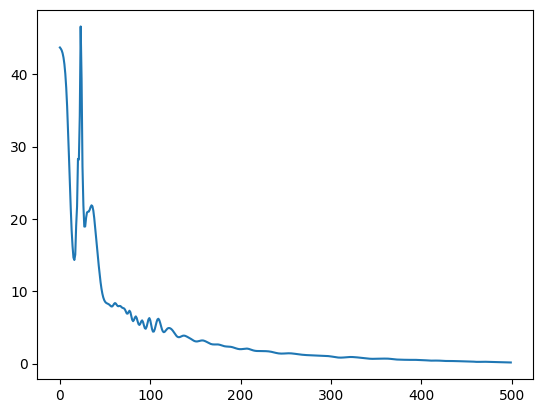

0.15680791796330595


In [35]:
#print loss
plt.plot(loss_arr)
plt.show()
print(loss_arr[-1])

In [36]:
#검증

total = 0
correct = 0

with torch.no_grad():
    for image,label in test_loader:
        x = image.to(device)
        y = label.to(device)

        output = model.forward(x)
        _,output_max = torch.max(output,1)
        
        total += label.size(0)
        correct += (output_max == y).sum()

print(f"total    : {total}")
print(f"correct  : {correct.cpu().numpy()}")
print(f"accuracy : {correct/total*100:.3}%")
        

total    : 9728
correct  : 9705
accuracy : 99.8%


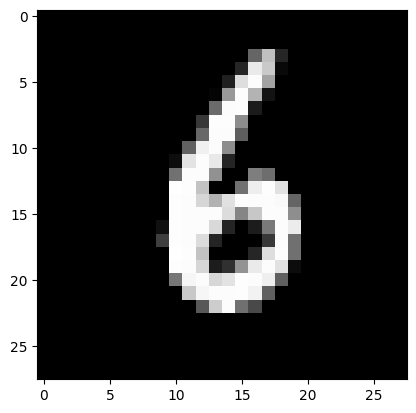

label : 6
infer : 6
True


In [37]:
#이미지 확인

random_num = np.random.randint(0, 10000)
image = mnist_test[random_num][0]

plt.imshow(image.reshape(-1,28),cmap="gray")
plt.show()
print(f"label : {mnist_test[random_num][1]}")
#infer
with torch.no_grad():
    output = model.forward(image.reshape([1,1,28,28]).to(device))
    _,output_max = torch.max(output,1)

print(f"infer : {int(output_max)}")
print(int(output_max)==mnist_test[random_num][1])



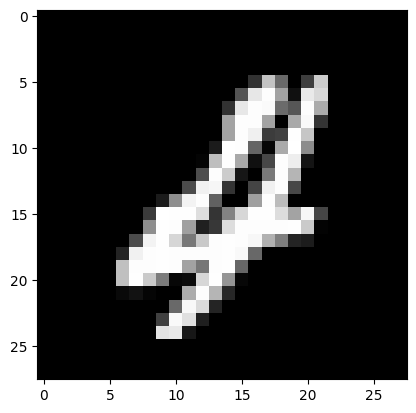

count : 5
------------------
label : 4
infer : 0
False


In [38]:
#틀렸을때의 출력
val = True
count = 0

while val:
    count+=1
    random_num = np.random.randint(0, 10000)
    image = mnist_test[random_num][0]
    
    #infer
    with torch.no_grad():
        output = model.forward(image.reshape([1,1,28,28]).to(device))
        _,output_max = torch.max(output,1)

    val = int(output_max)==mnist_test[random_num][1]

plt.imshow(image.reshape(-1,28),cmap="gray")
plt.show()
print(f"count : {count}")
print("------------------")
print(f"label : {mnist_test[random_num][1]}")
print(f"infer : {int(output_max)}")
print(int(output_max)==mnist_test[random_num][1])